In [6]:
import pandas as pd
'''
A. Predict the price of the Uber ride from a given pickup point to the agreed drop-off 
location. Perform following tasks:
1. Pre-process the dataset.
2. Identify outliers.
3. Check the correlation.
4. Implement linear regression and ridge, Lasso regression models.
5. Evaluate the models and compare their respective scores like R2, RMSE, etc.
Dataset link: https://www.kaggle.com/datasets/yasserh/uber-fares-dataset
'''
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [7]:
uber = pd.read_csv('uber.csv')
uber.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [8]:
uber.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [9]:
uber = uber.dropna()

In [10]:
uber.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [11]:
uber = uber.drop(['Unnamed: 0', 'key'], axis=1)
uber

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [12]:
# Convert 'pickup_datetime' to datetime
uber['pickup_datetime'] = pd.to_datetime(uber['pickup_datetime'], errors='coerce')

# Handle missing values (drop rows with missing 'pickup_datetime' or fare details)
uber = uber.dropna(subset=['pickup_datetime', 'fare_amount', 'pickup_longitude', 
                           'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count'])

# Extract features from 'pickup_datetime'
uber['hour'] = uber['pickup_datetime'].dt.hour
uber['day_of_week'] = uber['pickup_datetime'].dt.dayofweek
uber['month'] = uber['pickup_datetime'].dt.month

# Drop the 'pickup_datetime' column as we've extracted relevant information
uber = uber.drop(['pickup_datetime'], axis=1)

In [13]:
uber

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day_of_week,month
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,19,3,5
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,20,4,7
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,21,0,8
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,8,4,6
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,17,3,8
...,...,...,...,...,...,...,...,...,...
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,10,6,10
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,1,4,3
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,2,0,0,6
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,14,2,5


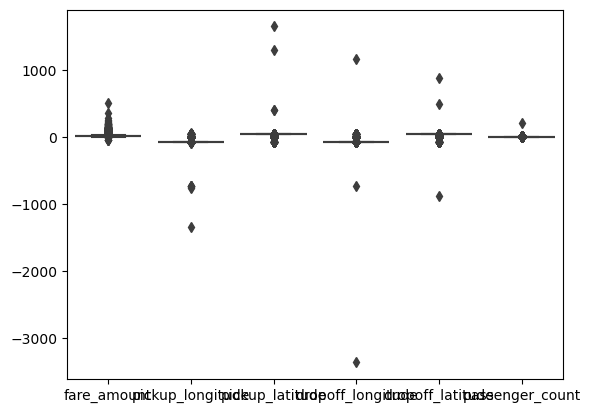

In [14]:
# Boxplot for numerical columns to detect outliers
sns.boxplot(data=uber[['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']])
plt.show()

# Remove outliers based on IQR (for fare_amount and geographical coordinates)
Q1 = uber[['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].quantile(0.25)
Q3 = uber[['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].quantile(0.75)
IQR = Q3 - Q1

uber = uber[~((uber[['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']] < (Q1 - 1.5 * IQR)) |(uber[['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']] > (Q3 + 1.5 * IQR))).any(axis=1)]

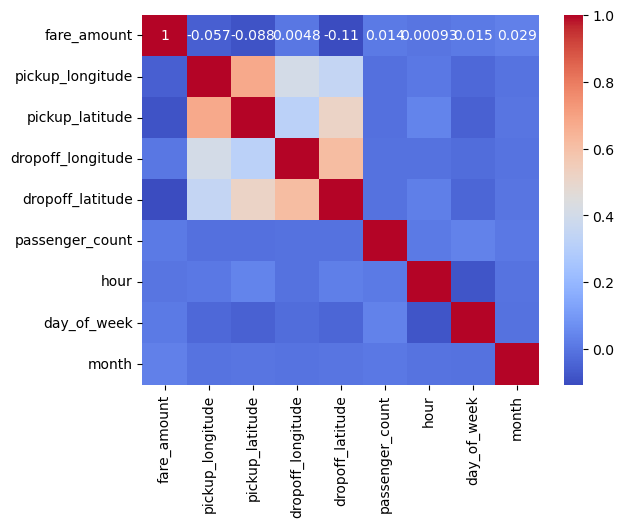

In [15]:
# Correlation heatmap
corr_matrix = uber.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [16]:
# Define features (X) and target (y)
X = uber.drop('fare_amount', axis=1)
y = uber['fare_amount']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Ridge Regression
ridge = Ridge(alpha=1)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

# Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

In [19]:
# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Linear Regression evaluation
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = rmse(y_test, y_pred_lr)

# Ridge Regression evaluation
r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = rmse(y_test, y_pred_ridge)

# Lasso Regression evaluation
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = rmse(y_test, y_pred_lasso)

# Print the model evaluation metrics
print(f"Linear Regression R2: {r2_lr}, RMSE: {rmse_lr}")
print(f"Ridge Regression R2: {r2_ridge}, RMSE: {rmse_ridge}")
print(f"Lasso Regression R2: {r2_lasso}, RMSE: {rmse_lasso}")

Linear Regression R2: 0.02310066501736241, RMSE: 3.8833559111468117
Ridge Regression R2: 0.023100619831145752, RMSE: 3.883356000958604
Lasso Regression R2: 0.017386803466674206, RMSE: 3.8946961824016144


In [20]:
# Done